In [282]:
import csv
import pandas as pd
import os
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import IsolationForest

In [283]:
# Read the file directly from GitHub repository (use raw URL and forward slashes)
url = "https://raw.githubusercontent.com/Negarhtf/Neospectra_Soil/main/SE_AI4SH_2024.csv"
csv_file_path = url
df_spectra_data = pd.read_csv(url)
print(df_spectra_data.head())  # Display the first few rows of the dataframe to verify loading

          Sample Name            Device Id          Created At (UTC)  \
0          60_20-50_2  NeoScanner_23040128  2024-11-07T10:48:30.000Z   
1          60_20-50_1  NeoScanner_23040128  2024-11-07T10:48:15.000Z   
2            60_20-50  NeoScanner_23040128  2024-11-07T10:48:00.000Z   
3  005-organic_0-20_2  NeoScanner_23040128  2024-11-07T10:41:36.000Z   
4  005-organic_0-20_1  NeoScanner_23040128  2024-11-07T10:41:21.000Z   

                      Created By  2549.999982  2541.176458  2532.413785  \
0  robert.minarik@opengeohub.org    37.797867    38.070241    38.315491   
1  robert.minarik@opengeohub.org    39.330422    39.616743    39.871226   
2  robert.minarik@opengeohub.org    40.900735    41.148264    41.370901   
3  robert.minarik@opengeohub.org    31.914594    31.926366    31.949304   
4  robert.minarik@opengeohub.org    30.888304    30.902142    30.925548   

   2523.711336  2515.068494  2506.484647  ...  1372.710602  1370.149576  \
0    38.522836    38.699997    38.871561 

In [284]:
# Load CSV file for spectra data
##csv_file_path = "C:/Users/hsfa0259/Desktop/Neospectra/SE_AI4SH_2024_DS.csv"  # location to the site data
#df_site_data = pd.read_csv(csv_file_path, index_col=0) # assuming the first column is index column

In [285]:
# Extract the base name by removing '_1' or '_2' (or any number) from the end
# BUT keep the original name if there's no suffix
df_spectra_data["Sample Name"] = df_spectra_data["Sample Name"].str.replace(r'(_\d+)$', '', regex=True)

# Group by the base name and calculate mean for all numeric columns
mean_df = df_spectra_data.groupby("Sample Name", as_index=False).mean(numeric_only=True)

# Save the results
mean_df.to_excel("mean_values.xlsx", index=False)

print(mean_df.head())  # Display the first few rows of the mean dataframe to verify


        Sample Name  2549.999982  2541.176458  2532.413785  2523.711336  \
0     001-sand_0-20    51.111271    51.231719    51.335209    51.409257   
1    001-sand_20-50    44.497667    44.658945    44.816686    44.984087   
2     002-sand_0-20    35.295046    35.464082    35.605984    35.710701   
3    002-sand_20-50    43.860983    44.188004    44.515867    44.812179   
4  003-organic_0-20    38.327573    38.350856    38.385045    38.418049   

   2515.068494  2506.484647  2497.959193  2489.491539  2481.081099  ...  \
0    51.459450    51.510129    51.594505    51.736268    51.944136  ...   
1    45.172003    45.388175    45.633077    45.902621    46.192581  ...   
2    35.787113    35.862196    35.970076    36.133601    36.359939  ...   
3    45.060214    45.269616    45.475655    45.714678    46.008114  ...   
4    38.451516    38.505020    38.607205    38.779468    39.029761  ...   

   1372.710602  1370.149576  1367.598087  1365.056084  1362.523513  \
0    46.001119    45.858416 

**Preprocessing for spectra data**

In [286]:

# === Step 1: Filtering using Savitzky-Golay ===
def apply_savitzky_golay(df, window_length=5, polyorder=2, mode='nearest'):
    """
    Apply Savitzky-Golay filter to smooth spectral data.
    
    :param df: DataFrame containing spectral data (wavelengths as columns)
    :param window_length: Window size for the filter (must be odd)
    :param polyorder: Polynomial order for smoothing
    :return: Smoothed DataFrame
    """
    # Adjust window_length based on number of spectral bands
    n_cols = df.shape[1]
    if window_length > n_cols:
        window_length = n_cols if n_cols % 2 == 1 else n_cols - 1
    if window_length % 2 == 0:
        window_length += 1

    # Apply Savitzky-Golay filter row-wise
    filtered_array = np.apply_along_axis(
        lambda row: savgol_filter(row, window_length, polyorder, mode=mode),
        axis=1,
        arr=df
    )

    # Convert back to DataFrame
    return pd.DataFrame(filtered_array, columns=df.columns, index=df.index)

# === Step 2: Scatter Correction using Standard Normal Variate (SNV) ===
def snv(input_data):
    """
    Applies Standard Normal Variate (SNV) to each row in the dataset.

    Parameters:
    - input_data (pd.DataFrame or np.ndarray): Spectral data.

    Returns:
    - pd.DataFrame: SNV-transformed data with the same shape as input.
    """

    # Ensure input is a NumPy array
    if isinstance(input_data, pd.DataFrame):
        input_array = input_data.to_numpy()
    else:
        input_array = input_data

    # Check for non-numeric data
    if not np.issubdtype(input_array.dtype, np.number):
        raise ValueError("SNV function received non-numeric data.")

    # Compute SNV (normalize each row)
    mean = np.mean(input_array, axis=1, keepdims=True)
    std_dev = np.std(input_array, axis=1, keepdims=True)
    std_dev[std_dev == 0] = 1e-8
    snv_array = (input_array - mean) / std_dev

    # Convert back to DataFrame if original was a DataFrame
    if isinstance(input_data, pd.DataFrame):
        return pd.DataFrame(snv_array, columns=input_data.columns, index=input_data.index)
    return snv_array


# === Step 3: Compute First Derivatives ===
def compute_first_derivative(df):
    """
    Compute the first derivative of spectral data.
    
    :param df: DataFrame containing spectral data
    :return: First derivative DataFrame
    """
    if isinstance(df, np.ndarray):  # Convert to DataFrame if it became an array
        df = pd.DataFrame(df)

    # Compute derivative using actual wavelength spacing
    wavelengths = df.columns.astype(float)
    arr = df.to_numpy(dtype=float)
    diffs = np.diff(arr, axis=1)
    delta = np.diff(wavelengths)
    delta[delta == 0] = 1e-8
    deriv_arr = diffs / delta
    derivative = pd.DataFrame(deriv_arr, columns=df.columns[1:], index=df.index)
    return derivative

# === Step 4: Remove Outliers using Isolation Forest ===
def remove_outliers(df, contamination=0.1):
    """
    Remove outliers using Isolation Forest.
    
    :param df: DataFrame containing spectral data
    :param contamination: Proportion of data expected to be outliers
    :return: Cleaned DataFrame
    """
    model = IsolationForest(contamination=contamination, random_state=42)
    labels = model.fit_predict(df)
    return df[labels == 1]  # Keep only inliers

In [287]:
# Separate sample names and spectral data
sample_names = mean_df.iloc[:, 0]               # First column = Sample Name
spectral_df = mean_df.iloc[:, 1:]               # All other columns = Wavelengths

# Step 1: Savitzky-Golay filter
spectral_df = apply_savitzky_golay(spectral_df, window_length=5, polyorder=2, mode='nearest')

# Step 2: SNV correction
spectral_df = snv(spectral_df)

# Step 3: First derivative
spectral_df = compute_first_derivative(spectral_df)

# Step 4: Remove outliers
spectral_df = remove_outliers(spectral_df, contamination=0.1)

# Reattach sample names to processed data
processed_df = pd.concat([sample_names.loc[spectral_df.index].reset_index(drop=True),
                          spectral_df.reset_index(drop=True)], axis=1)

# Optional: Save the result
processed_df.to_excel("processed_mean_df.xlsx", index=False)

print(processed_df.head())  # Display the first few rows of the processed dataframe to verify

         Sample Name  2541.176458  2532.413785  2523.711336  2515.068494  \
0      001-sand_0-20    -0.002022    -0.002617    -0.001731    -0.001202   
1     001-sand_20-50    -0.002835    -0.004188    -0.004077    -0.004615   
2      002-sand_0-20    -0.003576    -0.004619    -0.003120    -0.002319   
3     002-sand_20-50    -0.005868    -0.008453    -0.007149    -0.006046   
4  003-organic_20-50    -0.000594    -0.001645    -0.002848    -0.003994   

   2506.484647  2497.959193  2489.491539  2481.081099  2472.727295  ...  \
0    -0.001239    -0.002026    -0.003409    -0.005019    -0.006483  ...   
1    -0.005330    -0.006077    -0.006741    -0.007301    -0.007796  ...   
2    -0.002314    -0.003290    -0.005003    -0.006956    -0.008681  ...   
3    -0.005189    -0.005124    -0.005957    -0.007341    -0.008770  ...   
4    -0.005190    -0.006488    -0.007855    -0.009191    -0.010347  ...   

   1372.710602  1370.149576  1367.598087  1365.056084  1362.523513  \
0     0.012614     0.0

**Data Visualization**

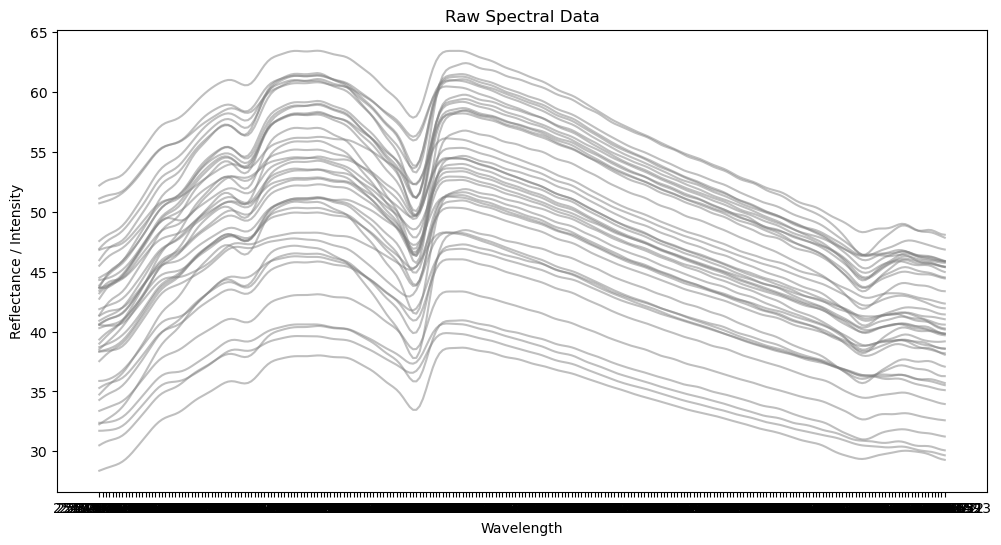

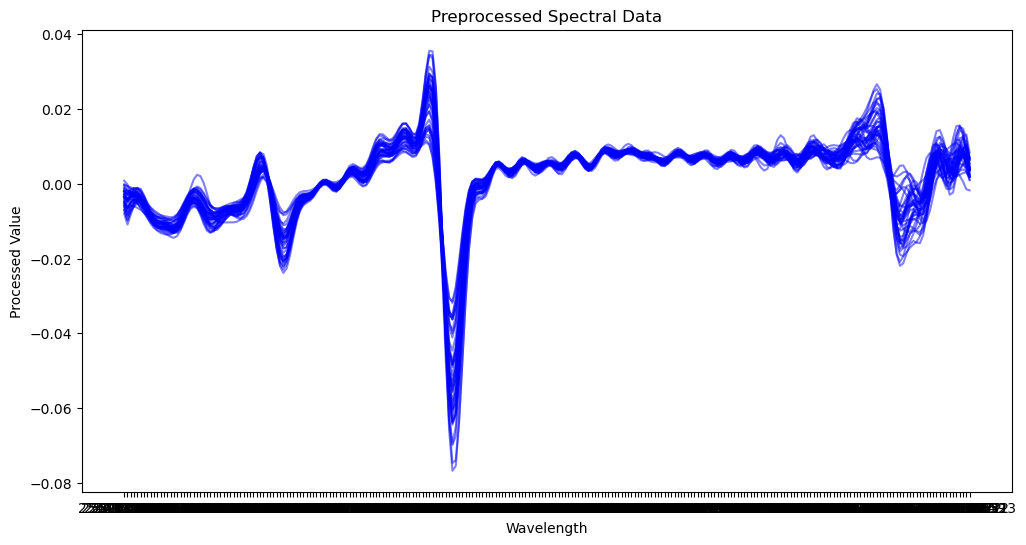

In [288]:
import matplotlib.pyplot as plt

# Plot the raw data
plt.figure(figsize=(12, 6))
for i in range(mean_df.shape[0]):
    plt.plot(mean_df.columns[1:], mean_df.iloc[i, 1:], color='gray', alpha=0.5)
plt.title("Raw Spectral Data")
plt.xlabel("Wavelength")
plt.ylabel("Reflectance / Intensity")
plt.show()

# Plot the processed data (excluding sample names)
plt.figure(figsize=(12, 6))
for i in range(processed_df.shape[0]):
    plt.plot(processed_df.columns[1:], processed_df.iloc[i, 1:], color='blue', alpha=0.5)
plt.title("Preprocessed Spectral Data")
plt.xlabel("Wavelength")
plt.ylabel("Processed Value")
plt.show()


**Load soil property data**
1. check the type of each column (float, int, string, etc.) -> to check if the data is numerical of object
2. check the missing values (NaN, None, etc.)
3. check the histogram of each properties #datawrangler
4. check the summary statistics of each properties
5. check the correlation statistics of the data

In [289]:
url = "https://raw.githubusercontent.com/Juuuuuuupiter/Neospectra_Soil/main/SE_Wetlab_Neospectra.csv"
csv_file_path = url
df_wetlab_data = pd.read_csv(url)
print(df_wetlab_data.head())  # Display the first few rows of the dataframe to verify loading

##convert data from string to numeric
##df_wetlab_data['pH_water'] = pd.to_numeric(df_wetlab_data['pH_water'], errors='coerce')


         Sample Name pH(water)  Electrical_conductivity(µS/cm)  \
0           60_20-50       6.5                              26   
1   005-organic_0-20       7.8                             117   
2  004-organic_20-50       7.8                              99   
3   003-organic_0-20       7.7                             130   
4   004-organic_0-20       7.6                             110   

   Total_organic_carbon(%)  Total_nitrogen(%)  Ca2+(cmol+/kg)  Mg2+(cmol+/kg)  \
0                    0.548               0.07            12.6             0.6   
1                    5.610               0.48            50.7             0.7   
2                    0.821               0.08            15.3             0.4   
3                    8.920               0.69            82.0             1.5   
4                    7.150               0.58            68.1             0.9   

   K+(cmol+/kg)  Na+(cmol+/kg)  Cation_exchange_capacity(cmol+/kg)  \
0          0.30          0.025                

In [290]:
#Statistical results of mean, SD, varance, min, max

import pandas as pd
import seaborn as sns

cols_to_cal = ["pH(water)","Electrical_conductivity(µS/cm)","Total_organic_carbon(%)","Total_nitrogen(%)","Ca2+(cmol+/kg)","Mg2+(cmol+/kg)","K+(cmol+/kg)","Na+(cmol+/kg)","Cation_exchange_capacity(cmol+/kg)","Olsen_Phosphorus(mg/100g)","Clay(<0.002 mm)","Fine_silt(0.002-0.02 mm)","Coarse_silt(0.02-0.06 mm)","Fine_sand(0.06-0.2 mm)","Coarse_sand(0.2 - 2.0 mm)"]
numeric_data = df_wetlab_data[cols_to_cal].apply(pd.to_numeric, errors='coerce')

stats = pd.DataFrame({
    "Mean": numeric_data.mean(),
    "Std Dev": numeric_data.std(),
    "Variance": numeric_data.var(),
    "Min": numeric_data.min(),
    "Max": numeric_data.max(),
    "Range": numeric_data.max() - numeric_data.min()
})

print(stats)

                                         Mean    Std Dev     Variance     Min  \
pH(water)                            6.743902   0.805310     0.648524   5.300   
Electrical_conductivity(µS/cm)      58.500000  32.461046  1053.719512  26.000   
Total_organic_carbon(%)              1.731119   1.883677     3.548238   0.373   
Total_nitrogen(%)                    0.158333   0.143032     0.020458   0.050   
Ca2+(cmol+/kg)                      18.002381  16.849064   283.890970   5.100   
Mg2+(cmol+/kg)                       0.604762   0.254666     0.064855   0.300   
K+(cmol+/kg)                         0.271429   0.219240     0.048066   0.050   
Na+(cmol+/kg)                        0.096429   0.067754     0.004591   0.025   
Cation_exchange_capacity(cmol+/kg)  20.523810   7.837490    61.426249   5.000   
Olsen_Phosphorus(mg/100g)            1.816667   1.278894     1.635569   0.500   
Clay(<0.002 mm)                     18.190476   4.655121    21.670151  10.000   
Fine_silt(0.002-0.02 mm)    

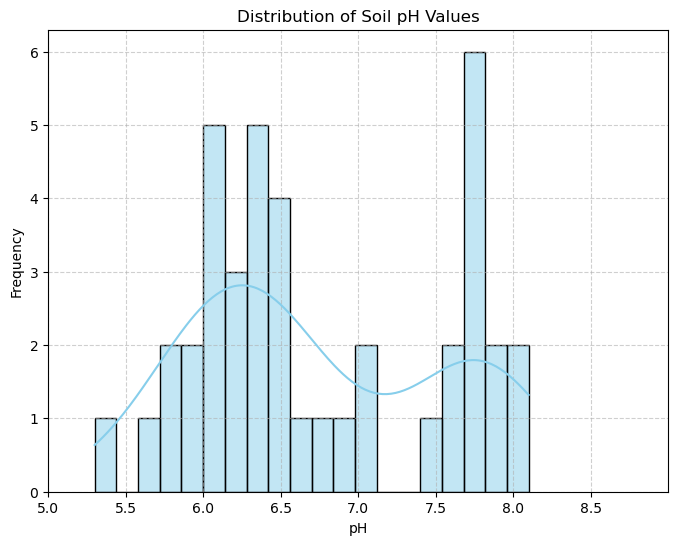

In [291]:
#frequency graphic of wetlab properties
plt.figure(figsize=(8, 6))
sns.histplot(pd.to_numeric(df_wetlab_data['pH(water)'], errors='coerce'), bins=20, kde=True, color='skyblue')

plt.title("Distribution of Soil pH Values")
plt.xlabel("pH")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim(5, 9)
plt.xticks(np.arange(5, 9, 0.5))

plt.show()

#make everything chemical properties into one figure

Input moisture leve data
Only when input fresh sample

**Match Spectral data with wet lab**

In [292]:
#harmonized into sample_name both df_wetlab_data'Sampel_Name' and processed_df'Sample Name'

df_wetlab_data['Sample Name'] = df_wetlab_data['Sample Name'].astype(str).str.strip()
processed_df['Sample Name'] = processed_df['Sample Name'].astype(str).str.strip()

#Check the data frame
print(df_wetlab_data.columns)
print(processed_df.columns)


Index(['Sample Name', 'pH(water)', 'Electrical_conductivity(µS/cm)',
       'Total_organic_carbon(%)', 'Total_nitrogen(%)', 'Ca2+(cmol+/kg)',
       'Mg2+(cmol+/kg)', 'K+(cmol+/kg)', 'Na+(cmol+/kg)',
       'Cation_exchange_capacity(cmol+/kg)', 'Olsen_Phosphorus(mg/100g)',
       'Clay(<0.002 mm)', 'Fine_silt(0.002-0.02 mm)',
       'Coarse_silt(0.02-0.06 mm)', 'Fine_sand(0.06-0.2 mm)',
       'Coarse_sand(0.2 - 2.0 mm)'],
      dtype='object')
Index(['Sample Name', '2541.176458', '2532.413785', '2523.711336',
       '2515.068494', '2506.484647', '2497.959193', '2489.491539',
       '2481.081099', '2472.727295',
       ...
       '1372.710602', '1370.149576', '1367.598087', '1365.056084',
       '1362.523513', '1360.000322', '1357.486459', '1354.981872',
       '1352.48651', '1350.000323'],
      dtype='object', length=257)


In [293]:
# Merge processed spectra with wet chemistry based on sample_name
matched_df = pd.merge(df_wetlab_data, processed_df, on=['Sample Name'], how="inner")

print("Matched samples:", matched_df.shape)
print(matched_df.head())

# Save the matched dataframes to Excel files
matched_df.to_csv("matched_df.csv", index=False)

Matched samples: (37, 272)
         Sample Name pH(water)  Electrical_conductivity(µS/cm)  \
0           60_20-50       6.5                              26   
1   005-organic_0-20       7.8                             117   
2  004-organic_20-50       7.8                              99   
3            91_0-20         6                              32   
4      002-sand_0-20       7.1                              46   

   Total_organic_carbon(%)  Total_nitrogen(%)  Ca2+(cmol+/kg)  Mg2+(cmol+/kg)  \
0                    0.548               0.07            12.6             0.6   
1                    5.610               0.48            50.7             0.7   
2                    0.821               0.08            15.3             0.4   
3                    1.380               0.15            13.7             0.7   
4                    1.730               0.15            15.5             0.7   

   K+(cmol+/kg)  Na+(cmol+/kg)  Cation_exchange_capacity(cmol+/kg)  ...  \
0          0.3

PermissionError: [Errno 13] Permission denied: 'matched_df.csv'

**ML model**

In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
#from cubist import Cubist

# === 1) Spectral columns ===
spectral_cols = [c for c in matched_df.columns if re.fullmatch(r'\d+(\.\d+)?', str(c))]

# === 2) Soil properties ===
soil_props = [
    'pH(water)',
    'Electrical_conductivity(µS/cm)',
    'Total organic carbon (%)',
    'Total nitrogen (%)',
    'Ca2+ (cmol+/kg)',
    'Mg2+ (cmol+/kg)',
    'K+ (cmol+/kg)',
    'Na+ (cmol+/kg)',
    'Cation exchange capacity (cmol+/kg)',
    'Olsen Phosphorus (mg/100g)',
    'Clay (<0.002 mm)',
    'Fine silt (0.002-0.02 mm)',
    'Coarse silt (0.02-0.06 mm)',
    'Fine sand (0.06-0.2 mm)',
    'Coarse sand (0.2 - 2.0 mm)'
]

In [247]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
#from cubist import Cubist

# === 1) Spectral columns ===
spectral_cols = [c for c in matched_df.columns if re.fullmatch(r'\d+(\.\d+)?', str(c))]

# === 2) Soil properties ===
soil_props = [
    'pH (water)',
    'Electrical conductivity(µS/cm)',
    'Total organic carbon (%)',
    'Total nitrogen (%)',
    'Ca2+ (cmol+/kg)',
    'Mg2+ (cmol+/kg)',
    'K+ (cmol+/kg)',
    'Na+ (cmol+/kg)',
    'Cation exchange capacity (cmol+/kg)',
    'Olsen Phosphorus (mg/100g)',
    'Clay (<0.002 mm)',
    'Fine silt (0.002-0.02 mm)',
    'Coarse silt (0.02-0.06 mm)',
    'Fine sand (0.06-0.2 mm)',
    'Coarse sand (0.2 - 2.0 mm)'
]

# === 3) Models ===
models = {
    'RF': RandomForestRegressor(n_estimators=300, random_state=42),
    'Cubist': Cubist(),
    'SVR': SVR(kernel='rbf'),
    'PLS': PLSRegression(n_components=10),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=2000, random_state=42)
}

# === 4) CV setup ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)), greater_is_better=False)

results = []

# === 5) Loop ===
for prop in soil_props:
    # Coerce and clean
    df = topsoil_matched_df.copy()
    df[prop] = pd.to_numeric(df[prop], errors='coerce')
    X = df[spectral_cols].apply(pd.to_numeric, errors='coerce')
    y = df[prop]

    # Drop rows with any NaN in X or y
    valid_idx = y.notna() & X.notna().all(axis=1)
    X_clean = X.loc[valid_idx]
    y_clean = y.loc[valid_idx]

    if len(y_clean) < 10:
        # too few samples for 10-fold CV
        continue

    for name, model in models.items():
        try:
            r2_scores = cross_val_score(model, X_clean, y_clean, cv=kf, scoring='r2')
            rmse_scores = -cross_val_score(model, X_clean, y_clean, cv=kf, scoring=rmse_scorer)
            results.append({
                'property': prop,
                'model': name,
                'n_samples': len(y_clean),
                'mean_r2': np.mean(r2_scores),
                'mean_rmse': np.mean(rmse_scores)
            })
        except Exception as e:
            results.append({
                'property': prop,
                'model': name,
                'n_samples': len(y_clean),
                'mean_r2': np.nan,
                'mean_rmse': np.nan,
                'error': str(e)
            })

# === 6) Summary ===
results_df = pd.DataFrame(results)
print(results_df.pivot(index='property', columns='model', values='mean_r2'))


NameError: name 'Cubist' is not defined

In [228]:
#PlSR
from sklearn.cross_decomposition import PLSRegression
# X is spectra and y is wetlab data
X = processed_df.iloc[:, 1:]
y = df_wetlab_data["Total_organic_carbon(%)"]

# Align X and y using valid_idx
X_valid = X[valid_idx.values]
y_valid = y[valid_idx.values]

pls = PLSRegression(n_components=10)
pls.fit(X_valid, y_valid)

# Fit PLSR 


#Cubist

#RF




ValueError: Item wrong length 44 instead of 37.